<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/medicinely/fwi/blob/main/testcode.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>

In [1]:
# !git clone https://github.com/medicinely/fwi.git
# %cd fwi

In [27]:
import time
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from scipy.optimize import minimize

from func.propagation import prop2d, defmodel
# from func.propagation_tf import simulate_obs
from func.inversion import J,second_order_derivative
from func.velocity_model import check_model, gaussian2d

import cupy as cp
device = 'gpu'


# Mapping function from u to v
def f(u, vmin=2000, vmax=3000):
    # CDF of gaussian
    cdf = sc.stats.norm.cdf(u.flatten(), loc=0, scale=1)
    v = (vmax-vmin)*cdf + vmin
    
    return v.reshape((nz,nx))

# Define cost function
def cost(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	# J: Prior part
	v = f(u)
	loss_J = J(v,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
	print("Loss (J) = %.4f " % loss_J, end='')
	# Q: Likelihood part
	u_sparse = sc.sparse.csc_matrix(u.flatten().reshape(-1,1))
	penalty = u_sparse.T.dot(Q).dot(u_sparse).toarray()
	# penalty = .5 * u.T.dot(Q.toarray()).dot(u) * alpha
	print("Penalty term = %.4f " % penalty, end='')
	# Total loss
	loss = loss_J + penalty
	print("Total loss = %.4f " % loss)
	# Save history
	global current_loss
	current_loss = np.array([loss,loss_J,penalty])

	return loss

# Calculate gradient with Adjoint state method
def gradiant(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	"""
	Calculate gradiant using adjoint state method
	"""
	# Calculate forward propagated p_fwd(z,x,t) (to update)
	v = f(u)
	nz, nx, nt = len(az), len(ax), len(at)
	if v.ndim == 1: v = np.reshape(v,(nz,nx))
	p_fwd = prop2d(wsrc,zxsrc,v,at,az,ax,next, device)
	receiver_depth = zxrec[0]
	d = p_fwd[zxrec[0], zxrec[1], :]
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back = prop2d(np.flip(residual,axis=1), zxrec, v, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=2)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	G = 2/v**3  * np.sum(p_back * p_dt_dt, axis=2) # G.shape = (201,201)

	u_sparse = sc.sparse.csc_matrix(u.flatten().reshape(-1,1))

	return G.flatten()*sc.misc.derivative(f,u).flatten() + Q.dot(u_sparse).toarray().flatten() * alpha

# Record loss history over each iterations
def callback(xk):
	global loss_tracker
	loss_tracker = np.vstack([loss_tracker,current_loss])

# Forward Propagation

In [28]:
# Import saved sample from prior

import pickle
# load data
filename = './data/u_ref'
infile = open(filename, 'rb')
u_ref = pickle.load(infile)
infile.close()

filename = './data/Q'
infile = open(filename, 'rb')
Q = pickle.load(infile)
infile.close()

# save data
# filename = './data/Q'
# outfile = open(filename, 'wb')
# pickle.dump(Q, outfile)
# outfile.close()

# Initialize the model axis az, ax, at
nz,nx,nt = 200,200,800
vmin,vmax = 2000,3000
izsrc, ixsrc = [nz//100], [nx//2]
next = 100

# u_ref, Q = gaussian2d(ranges = [100,20],param=1,nx=[nz,nx],variance=1,mean=0)
v_ref = f(u_ref)
print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]
# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 5 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx,interv)) #right
nrec = len(receivers_width)
# zxrec = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]), receivers_width)) # Bottom
zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]))) # Right
zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))
zxrec = np.unique(zxrec,axis=1)
print("Number of receivers:", len(zxrec.flatten())//2)
# # Propagajtion
p = prop2d(wsrc,zxsrc,v_ref,at,az,ax,next,device)
print("shape of p(z,x,t) =", p.shape)

Min velocity: 2006.27  Max velocity 2998.51
dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  200 200 800
Number of receivers: 156
shape of p(z,x,t) = (200, 200, 800)


# Observe data

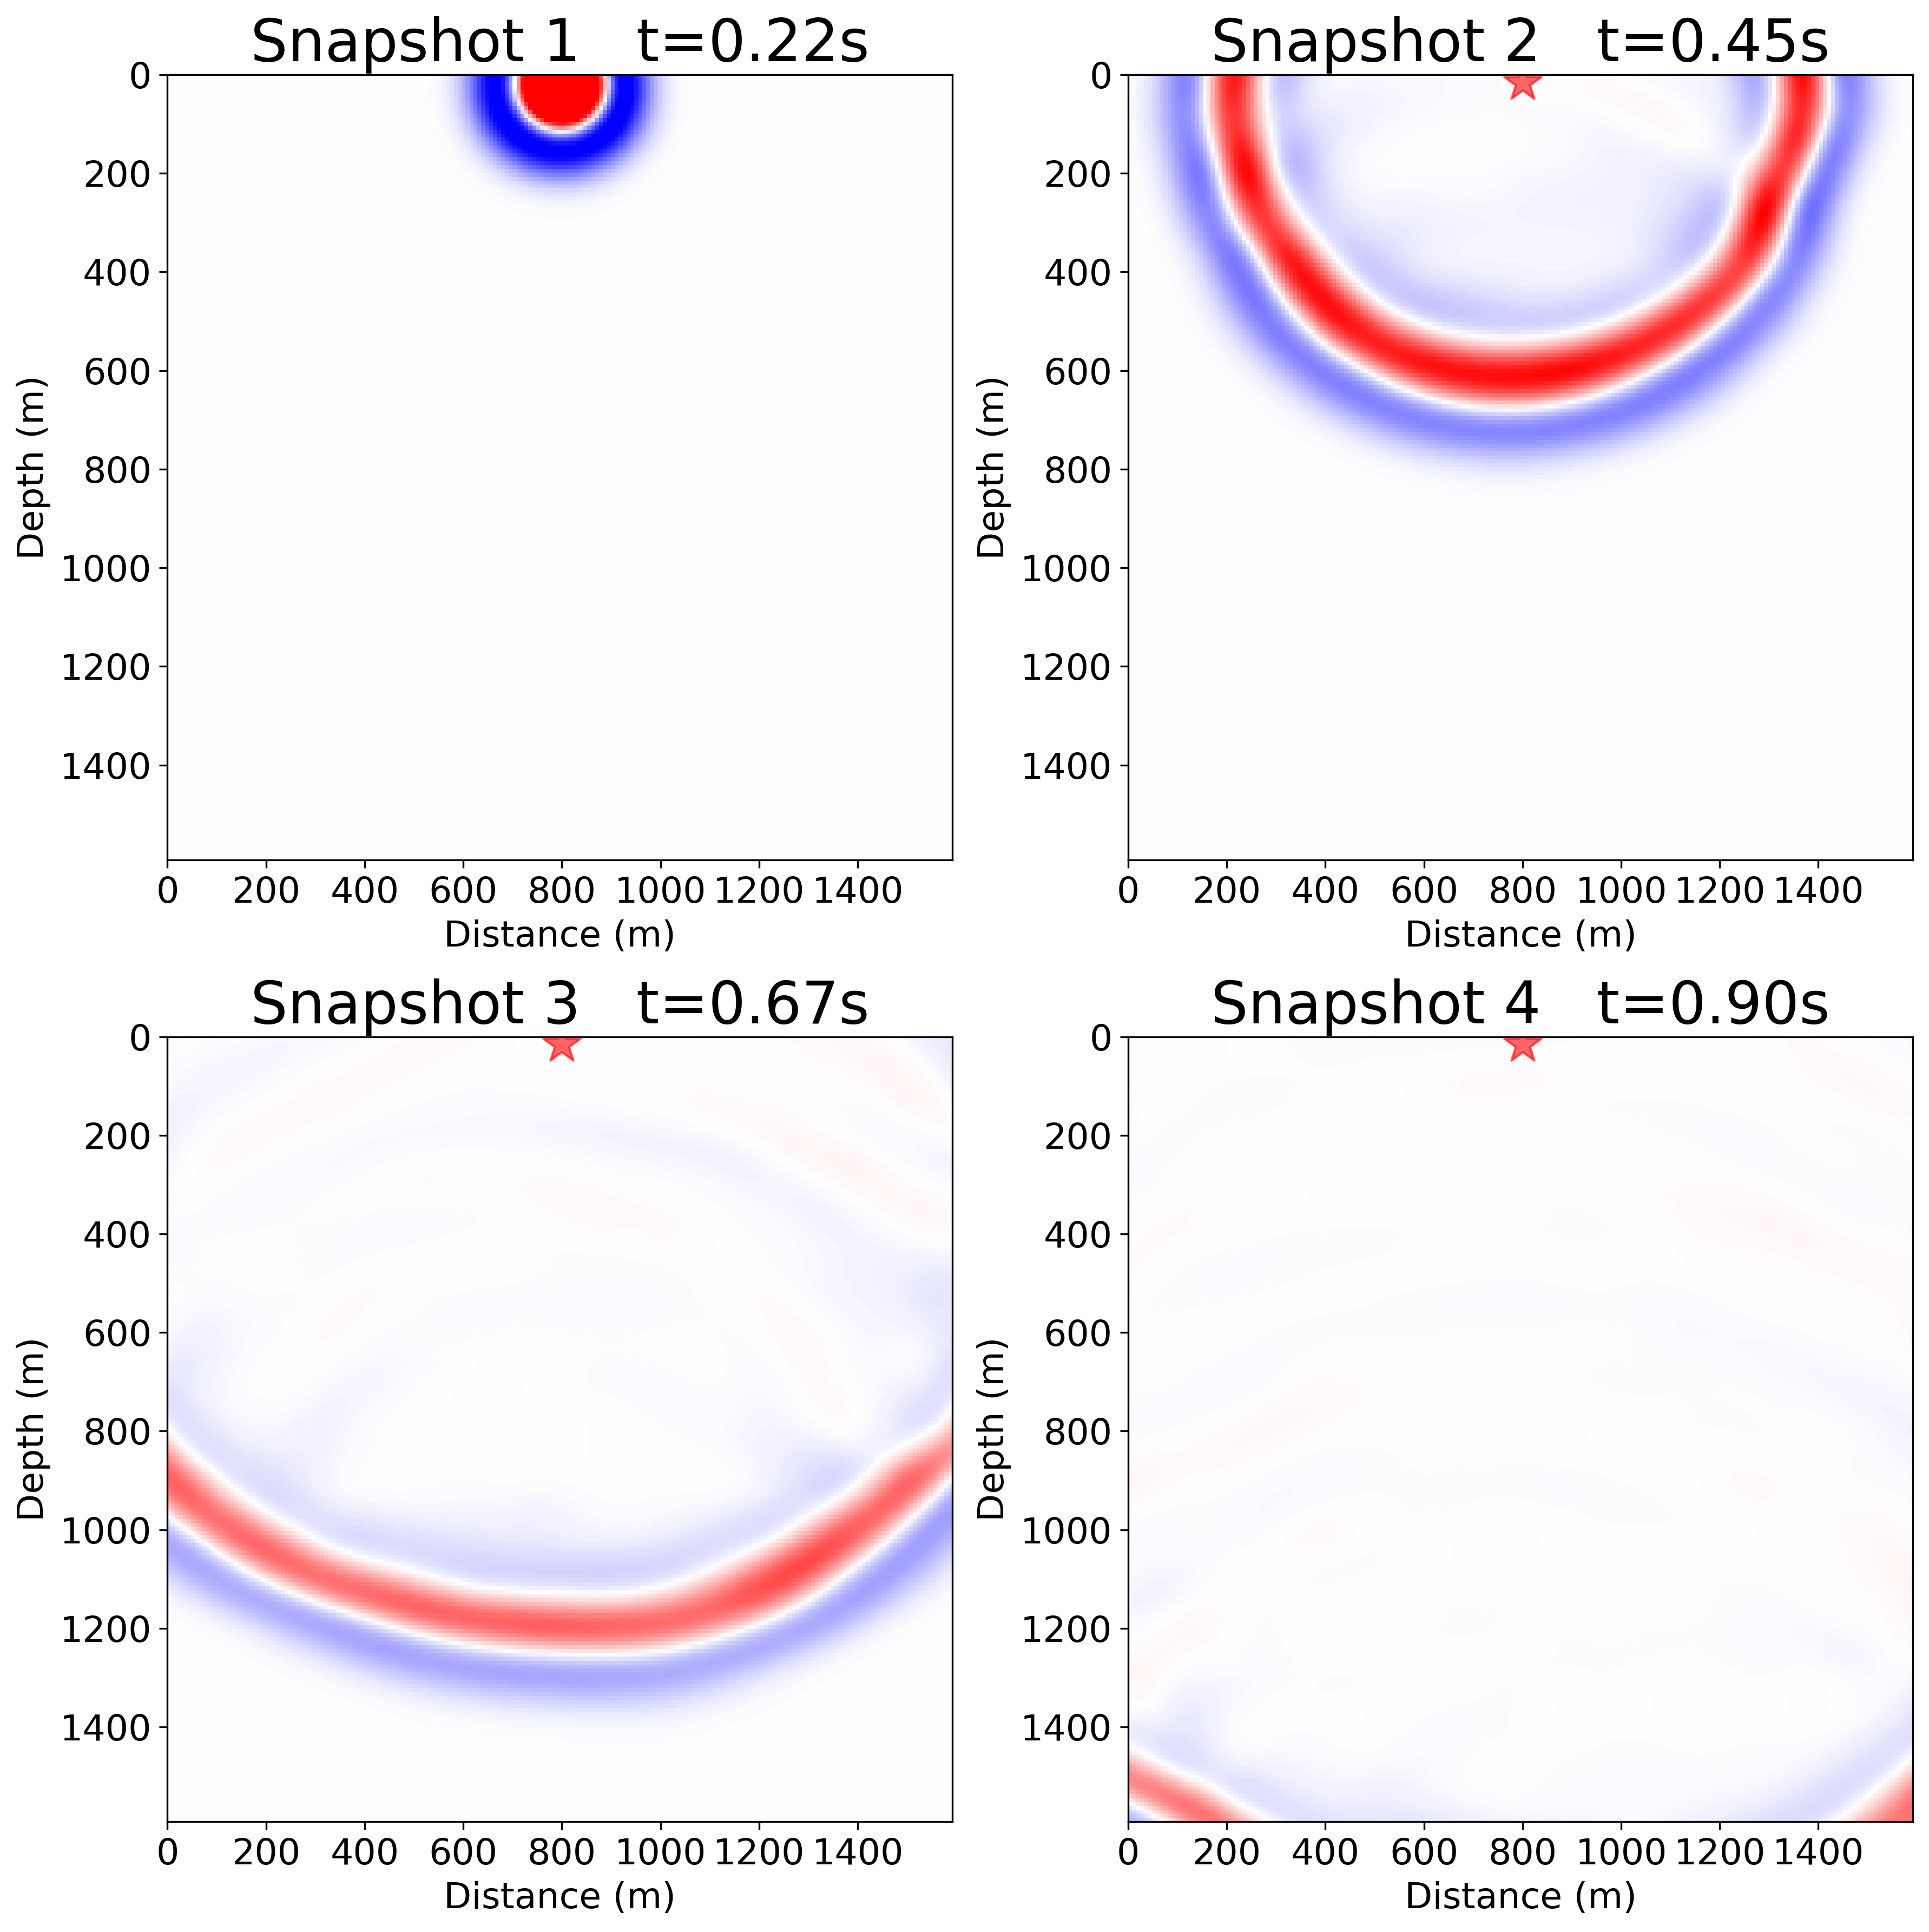

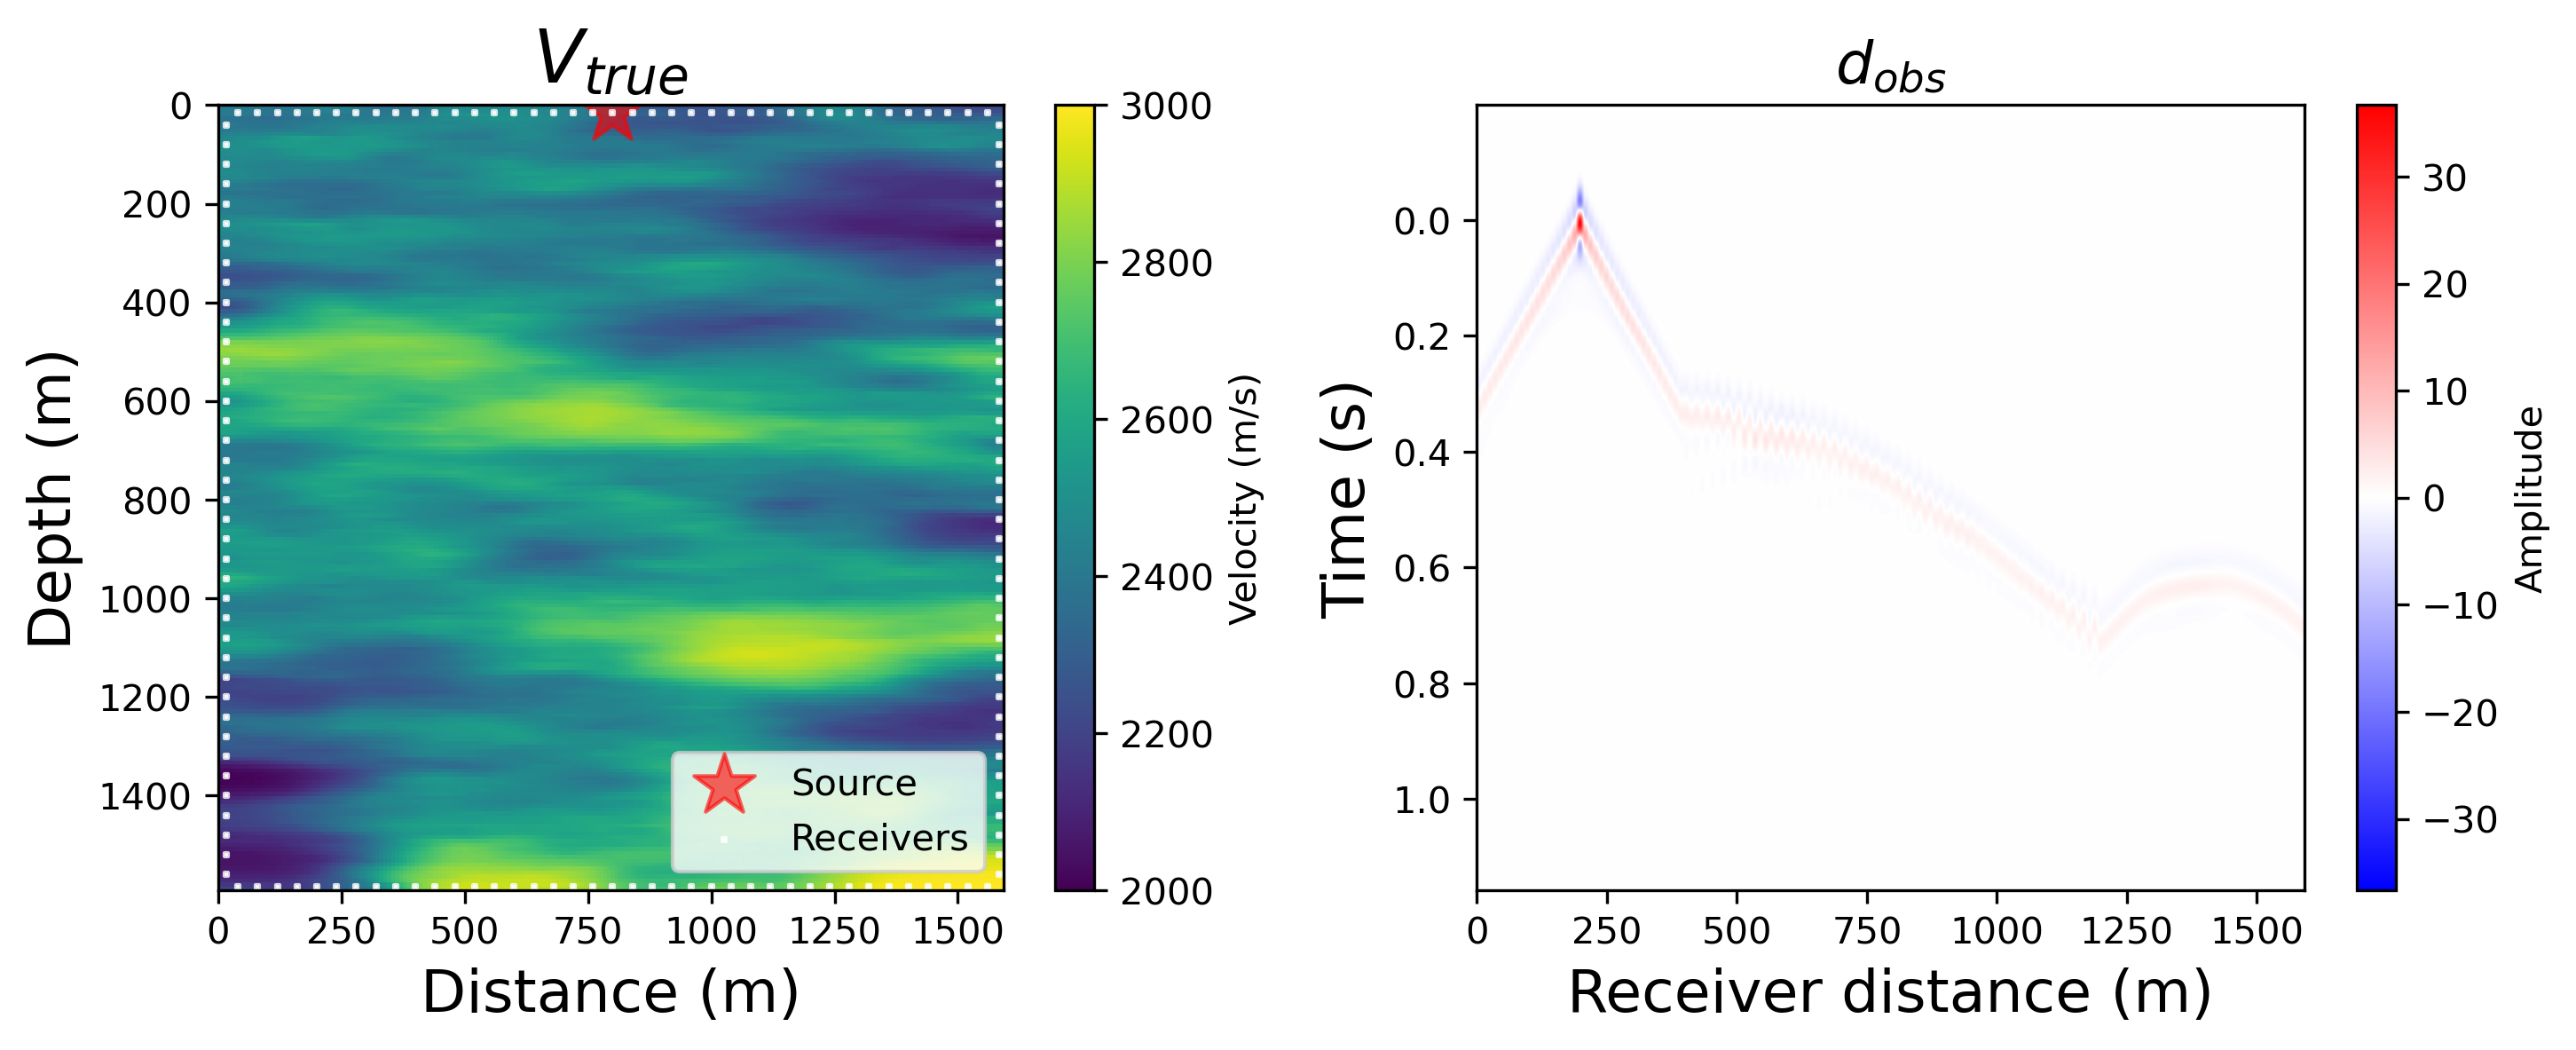

In [29]:
# std_noise = 1 # define the noise level
d_obs_no_noise = p[zxrec[0], zxrec[1], :]
d_obs = d_obs_no_noise
# d_obs = d_obs_no_noise + np.random.normal(0, std_noise, d_obs_no_noise.shape)
# print("Observation noise std =", std_noise)

labelsize = 16
plt.figure(figsize=(12,12), dpi=300,facecolor='white')
pmax = np.max(np.abs(p))/10.
for i in range(1,5):
    plt.subplot(2,2,i)
    t = int(i*(nt)) // 6
    plt.title('Snapshot '+str(i)+'   t='+str(t*dt)[:4]+'s',fontsize=labelsize+10)
    plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
    plt.imshow(p[:,:,t], cmap='bwr', vmin=-pmax, \
                vmax=pmax, extent=[ax[0],ax[-1],az[-1],az[0]], \
                aspect='equal')
    plt.xlabel('Distance (m)', fontsize=labelsize)
    plt.ylabel('Depth (m)', fontsize=labelsize)
    plt.xticks(fontsize=labelsize)
    plt.yticks(fontsize=labelsize)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,4),dpi=300)
plt.subplot(1,2,1) 
plt.imshow(v_ref,vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=0.8,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title("$V_{true}$",fontsize=labelsize+4)
plt.subplot(1,2,2)
maxd = np.abs(d_obs).max()
plt.imshow(d_obs.T,cmap='bwr',vmin=-maxd,vmax=maxd,extent=[az[0], az[-1],at[-1], at[0]], aspect='auto')
cbar = plt.colorbar()
cbar.set_label("Amplitude")
# plt.title("$d_{obs}$ with noise $\sigma_{Noise}$=%.2f  " % std_noise, fontsize=labelsize)
plt.title("$d_{obs}$", fontsize=labelsize)
plt.xlabel('Receiver distance (m)', fontsize=labelsize)
plt.ylabel('Time (s)', fontsize=labelsize)
plt.tight_layout()
plt.show()

# Minimization

In [30]:
# minimize cost function
start = time.time()
u_init = np.zeros([nz, nx])   # Set initial velocity guess (u=0 -> v=2500)
v_init = f(u_init)   # Initial v
loss_tracker = np.empty((0,3))

std_noise = 0.5 # define the noise level
alpha = std_noise**2 # Regularization parameter/weight (Variance of observation noise)

resi = minimize(fun = cost, 
               x0 = u_init.flatten(), 
               args = (d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha),
               method='L-BFGS-B', 
               # method='Newton-CG',
            #    bounds = np.full((len(u_init.flatten()), 2), (vmin,vmax)),
               jac = gradiant,
               options = {'disp':True, 'maxiter':10},
               callback=callback
              )
u_fwi = np.reshape(resi.x,(nz,nx))
v_fwi = f(u_fwi)
print(u_fwi.shape)
print('Total time',time.strftime("%Hh %Mm %Ss", time.gmtime(time.time()-start)))

Loss (J) = 5632.9572 Penalty term = 0.0000 Total loss = 5632.9572 


/tmp/ipykernel_4962/2792689559.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  current_loss = np.array([loss,loss_J,penalty])


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        40000     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.63296D+03    |proj g|=  2.44738D+01


 This problem is unconstrained.


Loss (J) = 5272.8484 Penalty term = 31.4568 Total loss = 5304.3052 
Loss (J) = 4051.1505 Penalty term = 786.4200 Total loss = 4837.5705 

At iterate    1    f=  4.83757D+03    |proj g|=  2.73573D+02
Loss (J) = 2464.0336 Penalty term = 8259.1390 Total loss = 10723.1726 
Loss (J) = 3754.5280 Penalty term = 682.4424 Total loss = 4436.9704 

At iterate    2    f=  4.43697D+03    |proj g|=  2.19265D+02
Loss (J) = 2457.1603 Penalty term = 1899.6281 Total loss = 4356.7884 

At iterate    3    f=  4.35679D+03    |proj g|=  2.14209D+02
Loss (J) = 2328.6695 Penalty term = 16150.5617 Total loss = 18479.2312 
Loss (J) = 2452.7440 Penalty term = 1818.7392 Total loss = 4271.4832 
Loss (J) = 2452.6237 Penalty term = 1816.6145 Total loss = 4269.2383 
Loss (J) = 2340.8492 Penalty term = 3928.8432 Total loss = 6269.6924 
Loss (J) = 2446.0516 Penalty term = 1707.0395 Total loss = 4153.0911 

At iterate    4    f=  4.15309D+03    |proj g|=  1.79529D+02
Loss (J) = 2390.4413 Penalty term = 1121.8896 Total l

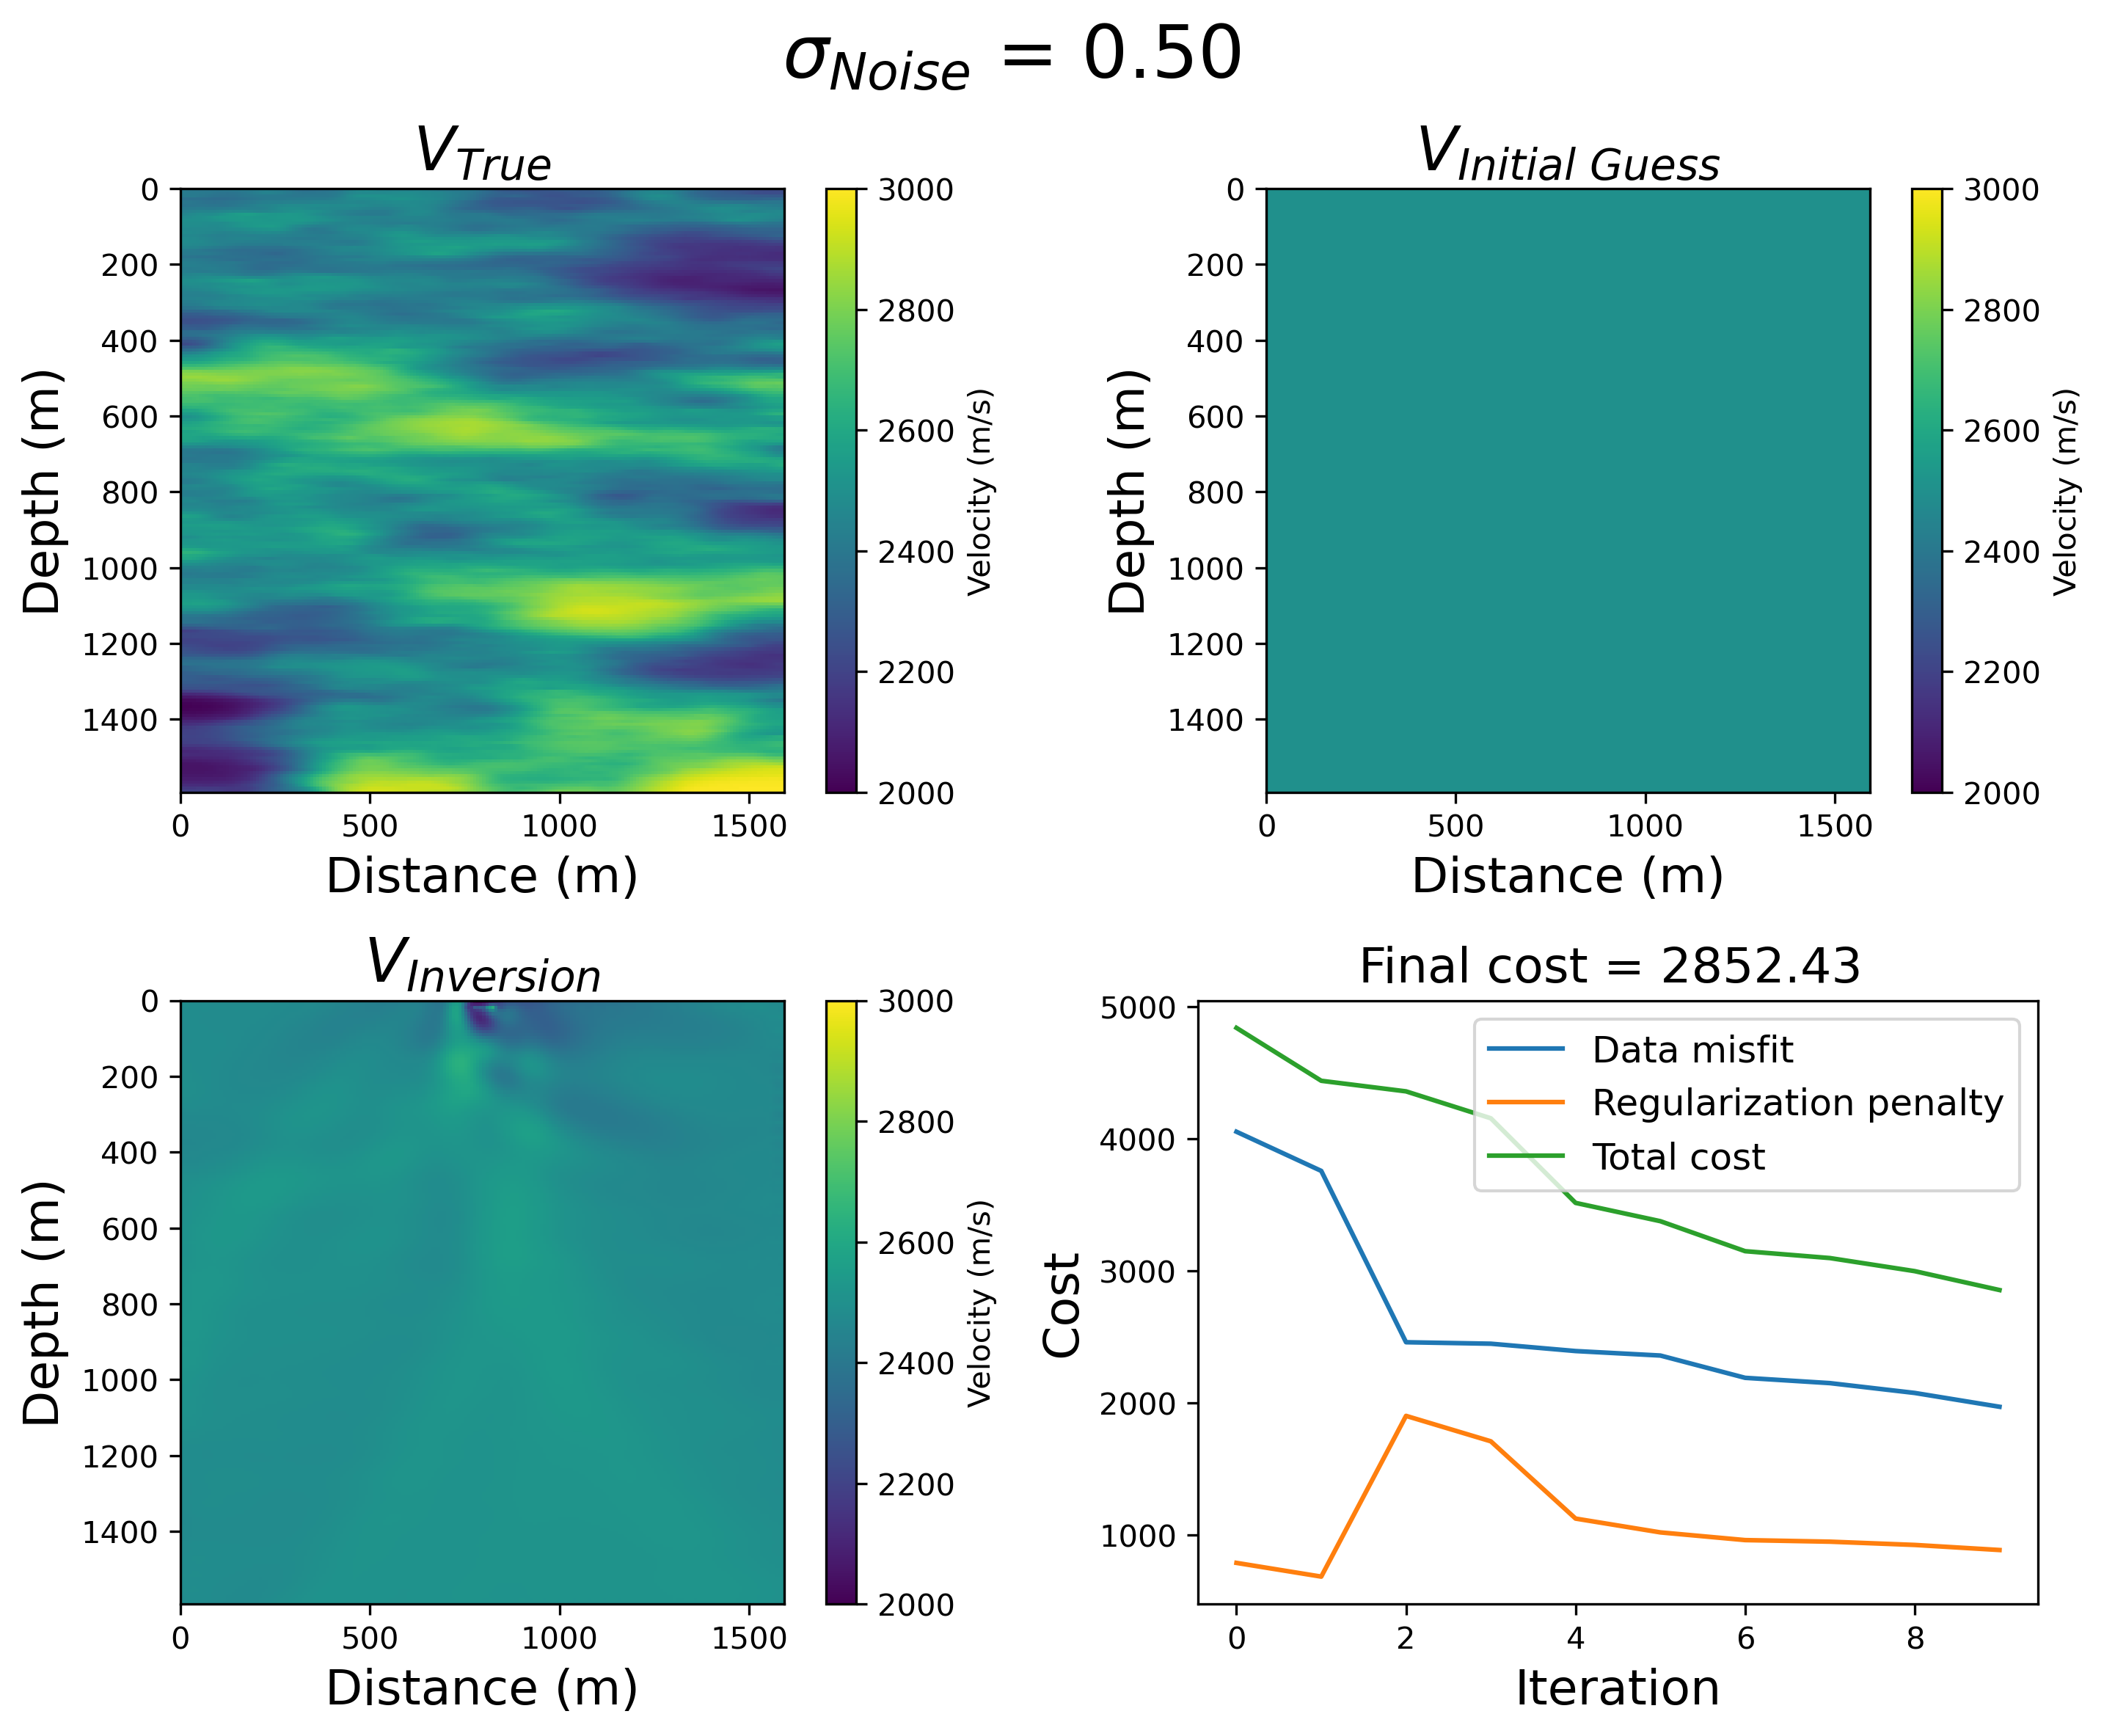

In [31]:
plt.figure(figsize=(10,8),dpi=300)
plt.suptitle("$\sigma_{Noise}$ = %.2f  " % std_noise,fontsize=labelsize+8)
# plt.suptitle("$Loss$ = %.2f " % loss_tracker[-1,0],fontsize=labelsize)
plt.subplot(2,2,1) 
plt.imshow(v_ref,vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title("$V_{True}$",fontsize=labelsize+4)
plt.subplot(2,2,2) 
plt.imshow(v_init,vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title("$V_{Initial\ Guess}$",fontsize=labelsize+4)
plt.subplot(2,2,3)
plt.imshow(v_fwi,vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
# plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=100,alpha=0.6,label="Source")
# plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=0.1,alpha=0.8,label="Receivers")
# plt.legend(loc='lower right')
# plt.title("$V_{Inversion}$ with $\sigma_{Noise}$ = %.2f " % std_noise)
plt.title("$V_{Inversion}$",fontsize=labelsize+4)
plt.subplot(2,2,4)
plt.title("Final cost = %.2f " % loss_tracker[-1,0],fontsize=labelsize)
plt.plot(loss_tracker[:,1],label="Data misfit")
plt.plot(loss_tracker[:,2],label="Regularization penalty")
plt.plot(loss_tracker[:,0],label="Total cost")
plt.xlabel("Iteration",fontsize=labelsize)
plt.ylabel("Cost",fontsize=labelsize)
# plt.xlim(0,150)
# plt.ylim(0,800)
plt.legend(fontsize=labelsize-4)
plt.tight_layout()
plt.show()

In [6]:
from scipy.sparse import csc_matrix
u = csc_matrix(u_ref.flatten().reshape(-1,1))
# result = u.dot(Q.dot(u))
result = u.T.dot(Q).dot(u).toarray()


In [26]:
# Calculate forward propagated p_fwd(z,x,t) (to update)
u = u_ref
v = f(u)
nz, nx, nt = len(az), len(ax), len(at)
if v.ndim == 1: v = np.reshape(v,(nz,nx))
p_fwd = prop2d(wsrc,zxsrc,v,at,az,ax,next, device)
receiver_depth = zxrec[0]
d = p_fwd[zxrec[0], zxrec[1], :]
residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
# Calculate back propagated p_back(z,x,t)
p_back = prop2d(np.flip(residual,axis=1), zxrec, v, at, az, ax, next, device)
p_back = np.flip(p_back,axis=2)
# Calculate second order time derivative of p_fwd(z,x,t)
p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
# Calculate gradiant
G = 2/v**3  * np.sum(p_back * p_dt_dt, axis=2) # G.shape = (201,201)

u_sparse = sc.sparse.csc_matrix(u.flatten().reshape(-1,1))

result = G.flatten()*sc.misc.derivative(f,u).flatten() + Q.dot(u_sparse).toarray().flatten() * alpha

Text(0.5, 1.0, 'Adjoint State gradiant')

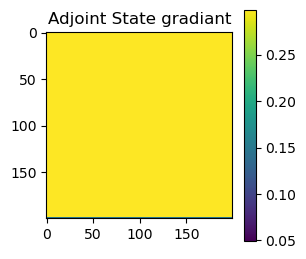

In [33]:
plt.figure(figsize=(3,3))
u_init = np.zeros([nz, nx])   # Set initial velocity guess (u=0 -> v=2500)
v_init = f(u_init)   # Initial v
g_adj = gradiant(v_init,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha).reshape(nz,nz)
plt.imshow(g_adj)
plt.colorbar() 
plt.title("Adjoint State gradiant")